**Using Logistic Regression, Gradient Descent and Support Vector Classifiers**

In [2]:
# Library imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

**Data Exploration**

- Load the Titanic dataset from Seaborn
- Document the columns that are missing both numerically (via a count) and visually (via an SNS heatmap)
- Document which values are categorical
- Explore the data and answer the following questions:
    - Did more women or men die on the Titanic?
    - Which passenger class was most likely to survive?
    - What does the distribution of fare look like?
    - What does the distribution of non-null age values look like?
    - What is the median age of each passenger class (pclass)? Visualize this in a boxplot.

In [3]:
# Load Titanic dataset
df = sns.load_dataset('titanic')
# df.head()  # Check for dataset import

# Document missing columns numerically via a count
df.isnull().sum()[df.isnull().sum() > 0]  # Print only columns where null count > 0

age            177
embarked         2
deck           688
embark_town      2
dtype: int64

<Axes: >

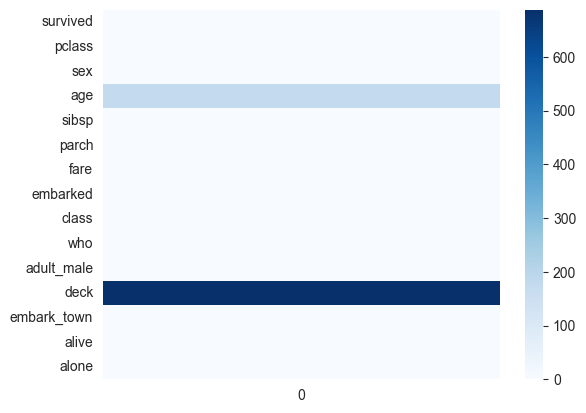

In [4]:
# Document missing columns numerically via a Seaborn heatmap
# Using the blue theme because the Titanic sunk in the ocean
sns.heatmap(data=df.isnull().sum().to_frame(), cmap='Blues')

In [4]:
# Document which values are categorical
# Apply a lambda function referencing the 'kind' attribute of each column
# The 'if' being passed to the lambda function represents integer or float columns, and the tilde (~) negates  
df.dtypes[~df.dtypes.apply(lambda x: x.kind in 'if')]  # These are all columns which are not int-type or float-type

sex              object
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

In [6]:
# Explore the data and answer the following questions:
# Did more women or men die on the titanic?
# Call count, group by 'sex' and 'survived' where survived = 0
df[df['survived'] == 0].groupby('sex')['survived'].count()

# ASSESSMENT: More men than women died on the Titanic

# Follow-up checks
# print(468 + 81)  # 549 deaths reported
# print(df[df['survived'] == 0]['survived'].count())  # Count of survived == 0 is 549

sex
female     81
male      468
Name: survived, dtype: int64

In [7]:
# Which passenger class was most likely to survive?
# Because 'survived' is binary where 1 is survival, the mean value of the column is survival rate
# Calculate the mean survival rate at the class level
df.groupby('pclass')['survived'].mean()

# ASSESSMENT: First-class passengers were most likely to survive

pclass
1    0.629630
2    0.472826
3    0.242363
Name: survived, dtype: float64

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64


<Axes: >

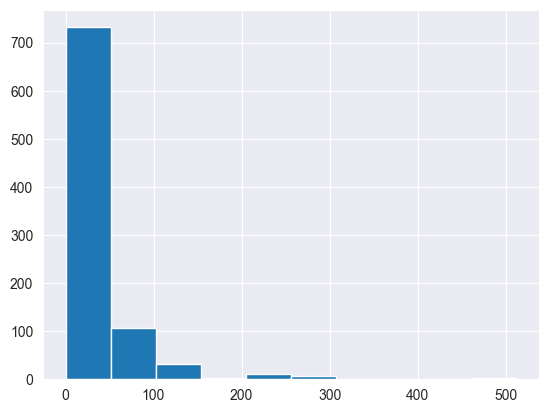

In [8]:
# What does the distribution of fare look like?

# First, look at descriptive statistics
print(df['fare'].describe())

# Then, plot a histogram
df['fare'].hist()

# ASSESSMENT: In terms of what the distribution of fare "looks like," it's heavily skewed right

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64


<Axes: >

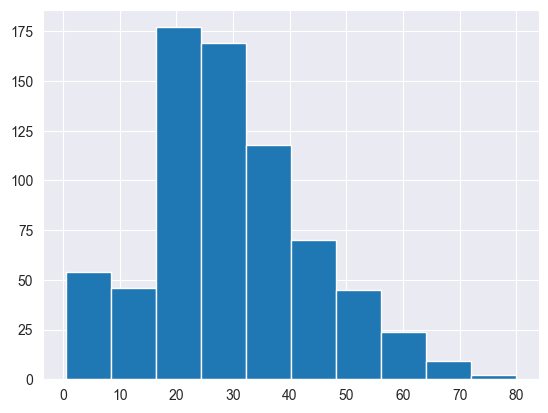

In [9]:
# What does the distribution of non-null age values look like?
# print(df['age'].isnull().sum())  # There are 177 missing values
# First, look at descriptive statistics
print(df['age'].describe())  # Count is correct - 714 + 177 = 891

# Note that the hist() method automatically handles missing values
df['age'].hist()

# ASSESSMENT: The non-null data for age are skewed right with the majority of the values concentrated 
# between 20 and 40 years old. This concentration is also apparent when looking at the quartile values

pclass
1    37.0
2    29.0
3    24.0
Name: age, dtype: float64


Text(0, 0.5, 'Age')

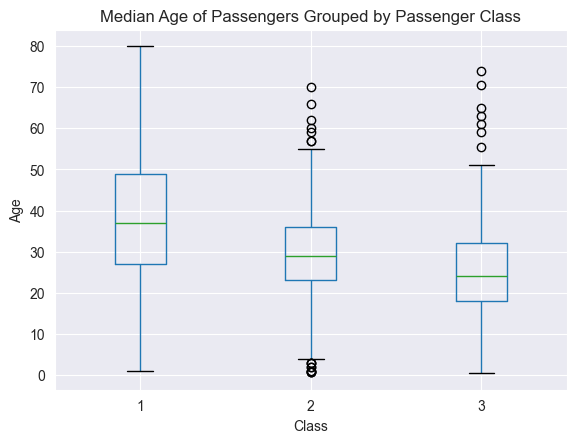

In [10]:
# What is the median age of each passenger class (pclass)?

# Numerical verifications for the plot
print(df.groupby('pclass')['age'].median())

# Creating a boxplot
df.boxplot(column='age', by='pclass')
plt.title('Median Age of Passengers Grouped by Passenger Class')
plt.suptitle('')
plt.xlabel('Class')
plt.ylabel('Age')

# ASSESSMENT: Median lines in boxplots appear to match calculated numerical values

**Data Cleansing**

- Since there are so many missing values in 'deck,' remove the 'deck' feature
- Define a lambda function to impute age using the median of the passenger class computed earlier
- Drop the remaining records containing null values, and show there are no remaining null values

**Note:**
Several of the remaining features are either duplicates of another feature, or engineered features from other features.
For example, pclass and class are identical, as well as alive and survived. 
Therefore, class, who, adult_male, alive, and embarked will be removed from the dataset. 
But, before removing these features, investigate who and adult_male, and identify the logic/relationship from the other features. 
The feature names should provide clues as to which features were used. 
Document which features were used to construct each of these two features and the logic employed.

- Convert categorical variables to numeric dummies using pandas’ get_dummies() method, and add these to the training dataframe.
- Create the feature set by dropping 'survived.' The resulting feature set should include pclass, age, sibsp, parch, fare, and the categorical dummy columns created earlier.
- Implement a target dataframe by copying the contents of the survived column of the training set to a new dataframe.
- Split the clean data into a training and test set.

In [11]:
# Remove the 'deck' feature
df.drop(columns='deck', inplace=True)  # Dropping column in-place for persistent change
# df.head()  # Print debugging

In [12]:
# Define a lambda function to impute age using the median of the passenger class computed earlier
# print(df['age'].isnull().sum())  # 177 missing values
df['age'] = df.groupby('pclass')['age'].transform(lambda x: x.fillna(x.median()))
print(df['age'].isnull().sum())  # Zero missing values after imputation

0


In [13]:
# Drop the remaining records containing null values, and show there are no remaining null values.
# By default, the dropna() method only deletes rows with missing data, not columns
df = df.dropna()
print(df.isnull().sum())  # All columns have zero missing values remaining

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    0
alive          0
alone          0
dtype: int64


In [14]:
# Note that class, who, adult_male, alive, and embarked will be removed from the dataset. 
# Before removing these features, investigate who and adult_male, and identify the logic/relationship from the other features. 
# The feature names should provide clues as to which features were used. 
# Document which features were used to construct each of these two features and the logic employed.

# Investigating the 'who' column
print(df['who'].unique())  # Values are man, woman, and child
print(df[df['who'] == 'child']['age'].max())  # Maximum age value for 'child' in the 'who' column is 15
print(df[df['who'] != 'child']['age'].min())  # Minimum age value for anyone NOT listed as 'child' is 16
# ASSESSMENT: The 'who' column was created by using the 'age' column to classify anyone under age 16 as a 'child.'
# Then, for anyone over age 15, the 'sex' column was used to define their 'who' value as 'man' or 'woman.'

# Investigating the 'adult_male' column
print(df['adult_male'].dtype)  # Datatype is Boolean
print(df[df['adult_male'] == True]['age'].min())  # Minimum age value where adult_male is True is 16
# ASSESSMENT: The 'adult_male' column was created by using the 'age' column to identify anyone over age 15 as 'adult.'
# Then, the 'sex' column was used to identify males. Any person with an age over 15 and a sex value of 'male' was classed as 'True' in the 'adult_male' column.

# Removing the class, who, adult_male, alive, and embarked fields from the dataframe
cols_to_drop = ['class', 'who', 'adult_male', 'alive', 'embarked']  # Create list of columns to drop
df.drop(columns=cols_to_drop, inplace=True)  # Drop columns in place
df.head()  # Check to ensure columns were dropped

['man' 'woman' 'child']
15.0
16.0
bool
16.0


C:\Users\doncs\AppData\Local\Temp\ipykernel_20180\767826132.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=cols_to_drop, inplace=True)  # Drop columns in place


,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,Southampton,False
1,1,1,female,38.0,1,0,71.2833,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,Southampton,True
3,1,1,female,35.0,1,0,53.1000,Southampton,False
4,0,3,male,35.0,0,0,8.0500,Southampton,True


In [15]:
# Convert categorical variables to numeric dummies using pandas’ get_dummies() method, and add them to the training dataframe
print(df.dtypes)  # Columns to transform are sex, embark_town, and alone
df = pd.get_dummies(df, columns=['sex', 'embark_town', 'alone'], prefix=['sex', 'embark', 'alone'], drop_first=True)
df.head()  # Dummy variables appear to be correctly-formatted

survived         int64
pclass           int64
sex             object
age            float64
sibsp            int64
parch            int64
fare           float64
embark_town     object
alone             bool
dtype: object


,survived,pclass,age,sibsp,parch,fare,sex_male,embark_Queenstown,embark_Southampton,alone_True
0,0,3,22.0,1,0,7.2500,True,False,True,False
1,1,1,38.0,1,0,71.2833,False,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True,True
3,1,1,35.0,1,0,53.1000,False,False,True,False
4,0,3,35.0,0,0,8.0500,True,False,True,True


In [21]:
# Create the feature set by dropping 'survived.' The resulting feature set should include pclass, age, sibsp, parch, fare, and the categorical dummy columns created earlier
feature_set = df.drop(columns='survived')
print(feature_set.columns)
feature_set.head()

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male',
       'embark_Queenstown', 'embark_Southampton', 'alone_True'],
      dtype='object')


,pclass,age,sibsp,parch,fare,sex_male,embark_Queenstown,embark_Southampton,alone_True
0,3,22.0,1,0,7.2500,True,False,True,False
1,1,38.0,1,0,71.2833,False,False,False,False
2,3,26.0,0,0,7.9250,False,False,True,True
3,1,35.0,1,0,53.1000,False,False,True,False
4,3,35.0,0,0,8.0500,True,False,True,True


In [17]:
# Implement a target dataframe by copying the contents of the survived column of the training set to a new dataframe
target_set = df['survived']
target_set.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [30]:
# Split clean data into a training and test set
# Stratifying by target set
feature_train, feature_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.2, stratify=target_set, random_state=4)

**Model Training**

- Implement a logistic regression model
- Implement a support vector classifier
- Implement an SGD classifier
- Print out the classification reports, confusion matrices, and roc score and chart for each of these

Classification Reports:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       439
           1       0.76      0.72      0.74       272

    accuracy                           0.81       711
   macro avg       0.80      0.79      0.79       711
weighted avg       0.81      0.81      0.81       711

Confusion Matrix:
[[379  60]
 [ 77 195]]
ROC Score:
0.8611818303631247


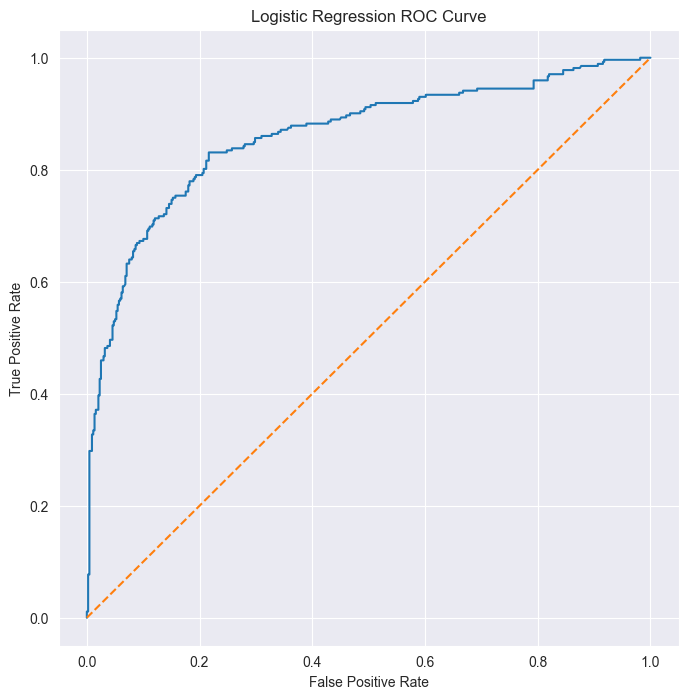

In [49]:
# Logistic regression model
log_reg = LogisticRegression(max_iter=500) # Instantiate, setting max_iter higher to stop error being thrown
# Make predictions using estimator
log_reg_preds = cross_val_predict(estimator=log_reg, X=feature_train, y=target_train, cv=5, method='predict_proba')
# Print out the classification reports, confusion matrices, and roc score and chart
print('Classification Reports:')
print(classification_report(y_true=target_train, y_pred=log_reg_preds[:, 1] >= 0.5))
print('Confusion Matrix:')
print(confusion_matrix(y_true=target_train, y_pred=log_reg_preds[:, 1] >= 0.5))
print('ROC Score:')
print(roc_auc_score(y_true=target_train, y_score=log_reg_preds[:, 1]))
fpr, tpr, thresh = roc_curve(target_train, log_reg_preds[:, 1])
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

Classification Reports:
              precision    recall  f1-score   support

           0       0.68      0.91      0.78       439
           1       0.67      0.31      0.43       272

    accuracy                           0.68       711
   macro avg       0.68      0.61      0.60       711
weighted avg       0.68      0.68      0.64       711

Confusion Matrix:
[[398  41]
 [187  85]]
ROC Score:
0.7084952431997857


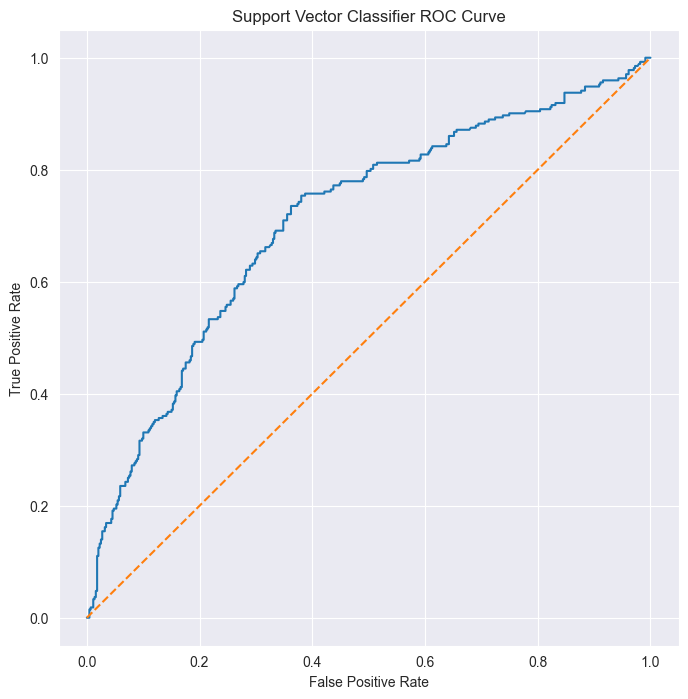

In [50]:
# Support Vector Classifier
svc = SVC(probability=True)  # Instantiate
# Make predictions using estimator
svc_preds = cross_val_predict(estimator=svc, X=feature_train, y=target_train, cv=5, method='predict_proba')
# Print out the classification reports, confusion matrices, and roc score and chart
print('Classification Reports:')
print(classification_report(y_true=target_train, y_pred=svc_preds[:, 1] >= 0.5))
print('Confusion Matrix:')
print(confusion_matrix(y_true=target_train, y_pred=svc_preds[:, 1] >= 0.5))
print('ROC Score:')
print(roc_auc_score(y_true=target_train, y_score=svc_preds[:, 1]))
fpr, tpr, thresh = roc_curve(target_train, svc_preds[:, 1])
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Support Vector Classifier ROC Curve')
plt.show()

Classification Reports:
              precision    recall  f1-score   support

           0       0.74      0.62      0.68       439
           1       0.52      0.65      0.58       272

    accuracy                           0.63       711
   macro avg       0.63      0.64      0.63       711
weighted avg       0.66      0.63      0.64       711

Confusion Matrix:
[[273 166]
 [ 94 178]]
ROC Score:
0.6541940238509982


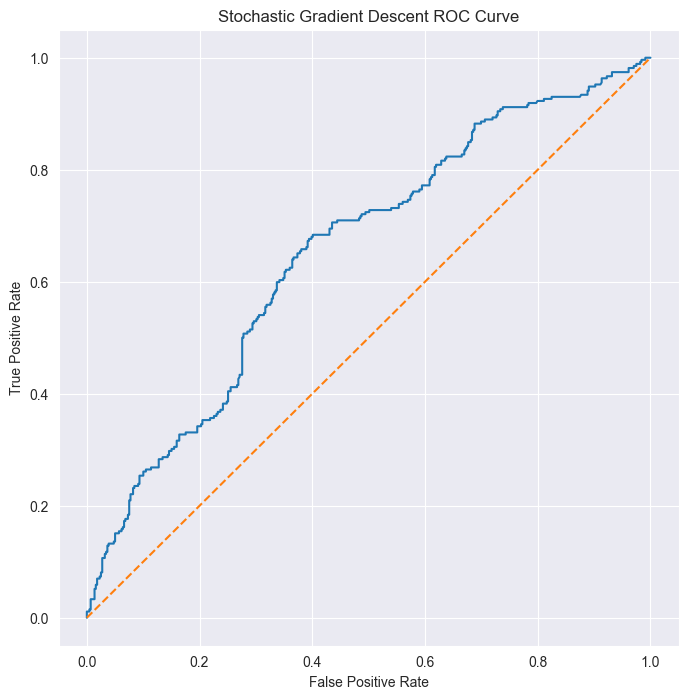

In [56]:
# SGD Classifier
sgd = SGDClassifier()  # Instantiate
# Make predictions using estimator
sgd_preds = cross_val_predict(estimator=sgd, X=feature_train, y=target_train, cv=5, method='decision_function')
# Print out the classification reports, confusion matrices, and roc score and chart
# Per sklearn dox at https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html:
# To make a classification report or confusion matrix for SGD using decision_function, we need to satisfy a binary case
# such that any decision score greater than or equal to 0 means the class would be predicted. 
# Therefore, we need to convert the decision scores into binarized 'guesses' for each instance into integers where a 1 represents any decision score >= 0.
binary_sgd_preds = (sgd_preds >= 0).astype(int)  # Convert decision scores to binary predictions
# print(binary_sgd_preds)  # Print debugging
print('Classification Reports:')
print(classification_report(y_true=target_train, y_pred=binary_sgd_preds))
print('Confusion Matrix:')
print(confusion_matrix(y_true=target_train, y_pred=binary_sgd_preds))

# I can directly supply the sgd predictions (non-binarized) to compute ROC score and plot the curve
print('ROC Score:')
roc_score = roc_auc_score(y_true=target_train, y_score=sgd_preds)
print(roc_score)
fpr, tpr, thresh = roc_curve(target_train, sgd_preds)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stochastic Gradient Descent ROC Curve')
plt.show()

**Model Tuning**

- See if scaling the input data affects your SVC model. Implement a sklearn pipeline to combine scaling and instantiation of the model.
- Do a grid search of your pipeline classifier using the following parameter grid:
*{‘ kernel’: [‘rbf’], ‘ gamma’: [0.0001, 0.001, 0.01, 0.1, 1], ‘{‘ C’:[1,10,50,100,200,300]}*
- Print the best estimator, its parameters, and the resulting score.
- Apply this estimator to the test set.

Classification Reports:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       439
           1       0.82      0.74      0.78       272

    accuracy                           0.84       711
   macro avg       0.83      0.82      0.82       711
weighted avg       0.84      0.84      0.83       711

Confusion Matrix:
[[395  44]
 [ 72 200]]
ROC Score:
0.8503952833980973


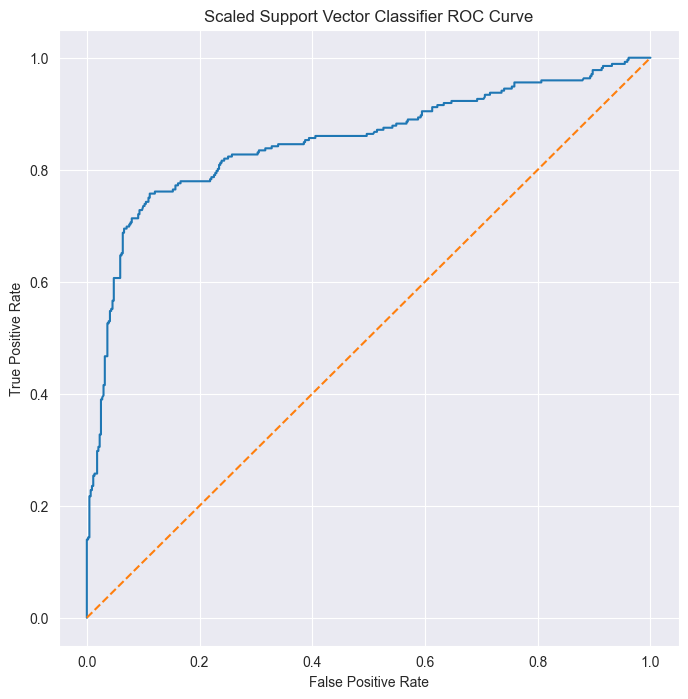

In [61]:
# Implement a sklearn pipeline to combine scaling and instantiation of the SVC model
svc_new = Pipeline([('Scaler', StandardScaler()), ('svc', SVC(probability=True))])

# See if scaling the input data affects the SVC model
svc_scaled_preds = cross_val_predict(estimator=svc_new, X=feature_train, y=target_train, cv=5, method='predict_proba')
# Print out the classification reports, confusion matrices, and roc score and chart
print('Classification Reports:')
print(classification_report(y_true=target_train, y_pred=svc_scaled_preds[:, 1] >= 0.5))
print('Confusion Matrix:')
print(confusion_matrix(y_true=target_train, y_pred=svc_scaled_preds[:, 1] >= 0.5))
print('ROC Score:')
print(roc_auc_score(y_true=target_train, y_score=svc_scaled_preds[:, 1]))
fpr, tpr, thresh = roc_curve(target_train, svc_scaled_preds[:, 1])
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Scaled Support Vector Classifier ROC Curve')
plt.show()

# ASSESSMENT: Scaling the input data improved the ROC score of the model and the appearance of the ROC curve

In [62]:
# Run a grid search of the pipeline classifier using the following parameter grid:
# {‘ kernel’: [‘rbf’], ‘ gamma’: [0.0001, 0.001, 0.01, 0.1, 1], ‘{‘ C’:[1,10,50,100,200,300]}

# Define parameter grid
parameter_grid = {
    'svc__kernel': ['rbf'],
    'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'svc__C': [1, 10, 50, 100, 200, 300]
}

# Perform the grid search
grid_search = GridSearchCV(estimator=svc_new, param_grid=parameter_grid, cv=5, scoring='roc_auc')
grid_search.fit(feature_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('svc', SVC(probability=True))]),
             param_grid={'svc__C': [1, 10, 50, 100, 200, 300],
                         'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'svc__kernel': ['rbf']},
             scoring='roc_auc')

In [70]:
# Print the best estimator, its parameters, and the resulting score
print('Best Estimator:')
print(grid_search.best_estimator_)
print('Parameters:')
print(grid_search.best_params_)
print('Score of Best Estimator:')
print(grid_search.best_score_)

# Apply this estimator to the test set
tuned_model = grid_search.best_estimator_
print('Score of Best Estimator on Test Set:')
print(tuned_model.score(feature_test, target_test))

Best Estimator:
Pipeline(steps=[('Scaler', StandardScaler()),
                ('svc', SVC(C=50, gamma=0.0001, probability=True))])
Parameters:
{'svc__C': 50, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
Score of Best Estimator:
0.8628677712337588
Score of Best Estimator on Test Set:
0.7247191011235955
